---
# Final Analyses

After `dn_compare.ipynb`, this notebook includes some of the final figures

In [32]:
from lazyplot import (
    plotting,
    glm,
    utils
)
import pingouin as pg
import os
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

opj = os.path.join
opd = os.path.dirname

In [26]:
glms = pd.read_csv(opj(opd(opd(plotting.__file__)),"data","glms.csv"), usecols=lambda column: not column.startswith("Unnamed"))
profs = pd.read_csv(opj(opd(opd(plotting.__file__)),"data","profiles.csv"), usecols=lambda column: not column.startswith("Unnamed")).set_index(["event_type","preproc","method","subject"])
betas = pd.read_csv(opj(opd(opd(plotting.__file__)),"data","betas.csv"), usecols=lambda column: not column.startswith("Unnamed")).set_index(["event_type","method","preproc","model","model_ix"])

glms.head()

,beta,tstat,r2,subject,model,model_ix,method,preproc,event_type
0,0.981313,2.956407,0.326860,8,linear,0,raw,uncorr,center
1,-0.398325,-1.404422,0.396841,8,camel,1,raw,uncorr,center
2,-1.791440,-2.029122,0.606952,8,camel_deriv,2,raw,uncorr,center
3,0.678075,3.011143,0.334983,10,linear,0,raw,uncorr,center
4,0.469938,2.792047,0.544059,10,camel,1,raw,uncorr,center


In [20]:
# initialize regressors
n_steps = profs.shape[-1]
xx = np.arange(0,n_steps)
y1 = xx.copy()[::-1]
y1 = y1/y1.max()

y2 = np.linspace(-n_steps//2,n_steps//2,num=n_steps)
y2 = (y2**2)
y2 = y2/y2.max()

y = np.linspace(-10,10,num=20)
# print(y2.shape)
# y2 = (y2**2)
fc = 5
y_1 = stats.norm.pdf(y,-fc)
y_1 = y_1/y_1.max()
y_1d = np.gradient(y_1)

y_2 = stats.norm.pdf(y,fc)
y_2 = y_2/y_2.max()
y_2d = np.gradient(y_2)

y3 = y_1+y_2

reg_dict = {
    "linear": y1[...,np.newaxis],
    "camel": np.concatenate(
        [
            y1[...,np.newaxis],     # linear term
            y3[...,np.newaxis],    # fixed bumps
        ],
        axis=1
    )
}

# combine linear & camel
reg_dict["camel_deriv"] = np.concatenate(
    [
        y1[...,np.newaxis],     # linear term
        y_1[...,np.newaxis],    # first bump
        y_2[...,np.newaxis],    # second bump
        y_1d[...,np.newaxis],   # first bump deriv
        y_2d[...,np.newaxis]    # second bump deriv
    ],
    axis=1
)


              W      pval  normal
beta  0.948999  0.124379    True

        Source  ddof1  ddof2         F     p-unc       np2
0  event_type      2     30  7.107614  0.002973  0.321501


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen,distances
0,event_type,center,large\nannulus,True,True,-4.005559,10.0,two-sided,0.002496,0.007488,holm,18.86,-1.369197,2
1,event_type,center,medium\nannulus,True,True,-3.146138,10.0,two-sided,0.010401,0.020802,holm,5.864,-1.505014,1
2,event_type,large\nannulus,medium\nannulus,True,True,1.330295,10.0,two-sided,0.212961,0.212961,holm,0.603,0.571084,1


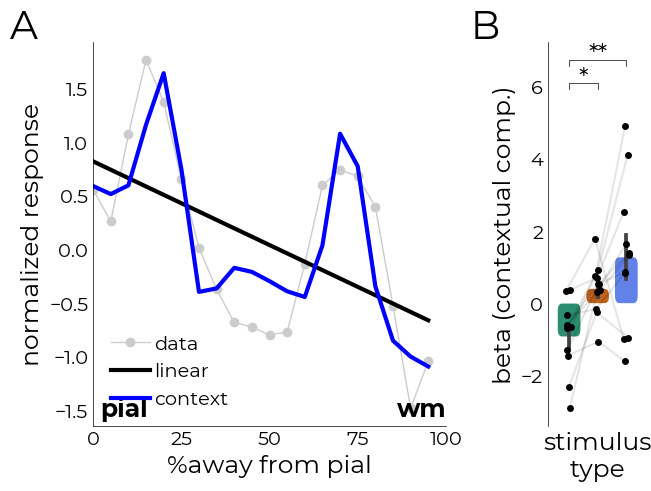

In [36]:
%matplotlib inline
n_elem = betas.shape[1]

colors = sns.color_palette("viridis", n_elem)
ev = "large\nannulus"
expr = [
    f"event_type = {ev}",
    "method = norm"
]

be = utils.multiselect_from_df(
    betas,
    expression=expr
)

data = utils.multiselect_from_df(profs, expression=expr+["preproc = corr","method = norm"]).values.T

icpt = np.ones((data.shape[0],1))
fig,axs = plt.subplots(
    ncols=2, 
    width_ratios=[0.8,0.2], 
    constrained_layout=True
)

ix = 0
sub_name = f"sub-{str(ix+1).zfill(2)}"
lbl = {
    "linear": "linear",
    "camel": "double",
    "camel_deriv": "context"
}

incl_models = [
    "linear",
    "camel_deriv"
]
data_list = [data[:,ix]]
# cm = sns.color_palette("Reds", len(incl_models))
cm = ["k","b"]

for key,val in reg_dict.items():
    
    if key in incl_models:
        be1 = utils.select_from_df(be, expression=f"model = {key}").values
        dm = np.concatenate([icpt,val], axis=-1)

        y_hat = np.dot(dm,be1)
        data_list.append(y_hat[:,ix])

ddict = plotting.make_wm_pial_ticks(data_list[0])
def_dict = {
    "color": ["#cccccc"]+cm,
    "axs": axs[0],
    "line_width": [1]+[3 for i in range(len(incl_models))],
    "markers": ["o"]+[None for i in range(len(incl_models))],
    "labels": ["data"]+[lbl[i] for i in incl_models],
    "x_ticks": ddict["ticks"],
    "x_ticklabels": ddict["labels"],
    "x_label": "%away from pial",
    "y_label": "normalized response",
}

pl = plotting.LazyLine(
    data_list,
    **def_dict
)

plotting.annotate_cortical_ribbon(
    axs[0],
    pial_pos=(0.02,0.025),
    wm_pos=(0.86,0.025),
    fontsize=pl.font_size,
    fontweight="bold"
)

stat = "beta"
if stat == "tstat":
    lbl = "t-stat"
else:
    lbl = stat
    
br = plotting.LazyBar(
    utils.multiselect_from_df(
        glms,
        expression=[
            "preproc = corr",
            "method = norm",
            "model = camel_deriv"
        ]
    ),
    x="event_type",
    y=stat,
    x_label="stimulus\ntype",
    axs=axs[1],
    add_points=True,
    points_color="k",
    y_label=f"{lbl} (contextual comp.)",
    sns_offset=4,
    bar_legend=True,
    sns_rot=-25,
    # title={
    #     "title": f"{key} | {vi}",
    #     "fontweight": "bold"
    # },
    bbox_to_anchor=(0.8,0.9),
    fancy=True,
    palette=["#1B9E77","#D95F02","#4c75ff"],
    connect=True
)


normality = pg.normality(br.data[br.y])
is_normal = normality["normal"][0]

aov = glm.ANOVA(
    data=br.data,
    dv=br.y,
    between=br.x,
    # test="test",
    parametric=is_normal,
    posthoc_kw={
        "effsize": "cohen",
        "test": "test",
        "paired": True,
        "subject": "subject",
        "padjust": "holm"
    }
)

aov.plot_bars( 
    axs=br.ff,
    ast_frac=0,
    y_pos=1.15,
    line_separate_factor=-0.075
)

plotting.fig_annot(
    fig,
    axs=list(fig.axes),
    x0_corr=-0.85,
    x_corr=[-0.85]
)

print("\n", normality)
print("\n", aov.ano)
aov.posthoc